<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Algorithmic Trading

**Chapter 10 &mdash; Automating Trading Operations**

## Risk Disclaimer

<font size="-1">
Trading forex/CFDs on margin carries a high level of risk and may not be suitable for all investors as you could sustain losses in excess of deposits. Leverage can work against you. Due to the certain restrictions imposed by the local law and regulation, German resident retail client(s) could sustain a total loss of deposited funds but are not subject to subsequent payment obligations beyond the deposited funds. Be aware and fully understand all risks associated with the market and trading. Prior to trading any products, carefully consider your financial situation and experience level. Any opinions, news, research, analyses, prices, or other information is provided as general market commentary, and does not constitute investment advice. Oanda & TPQ will not accept liability for any loss or damage, including without limitation to, any loss of profit, which may arise directly or indirectly from use of or reliance on such information.
</font>

## Author Disclaimer

<font size="-1">
The author is neither an employee, agent nor representative of Oanda and is therefore acting independently. The opinions given are their own, constitute general market commentary, and do not constitute the opinion or advice of Oanda or any form of personal or investment advice. Oanda assumes no responsibility for any loss or damage, including but not limited to, any loss or gain arising out of the direct or indirect use of this or any other content. Trading forex/CFDs on margin carries a high level of risk and may not be suitable for all investors as you could sustain losses in excess of deposits.
</font>

In [43]:
import math
import time
import numpy as np
import pandas as pd
import datetime as dt
from pylab import plt, mpl

In [44]:
np.random.seed(1000)
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'

In [45]:
import warnings
warnings.simplefilter('ignore')

## Capital Management

### Kelly Criterion in a Binomial Setting

In [46]:
p = 0.55

In [47]:
f = p - (1 - p)

In [48]:
f

0.10000000000000009

In [49]:
I = 50

In [50]:
n = 100

In [51]:
def run_simulation(f):
    c = np.zeros((n, I))
    c[0] = 100
    for i in range(I):
        for t in range(1, n):
            o = np.random.binomial(1, p)
            if o > 0:
                c[t, i] = (1 + f) * c[t - 1, i]
            else:
                c[t, i] = (1 - f) * c[t - 1, i]
    return c

In [52]:
c_1 = run_simulation(f)

In [53]:
c_1.round(2)

array([[100.  , 100.  , 100.  , ..., 100.  , 100.  , 100.  ],
       [ 90.  , 110.  ,  90.  , ..., 110.  ,  90.  , 110.  ],
       [ 99.  , 121.  ,  99.  , ..., 121.  ,  81.  , 121.  ],
       ...,
       [226.35, 338.13, 413.27, ..., 123.97, 123.97, 123.97],
       [248.99, 371.94, 454.6 , ..., 136.37, 136.37, 136.37],
       [273.89, 409.14, 409.14, ..., 122.73, 150.01, 122.73]])

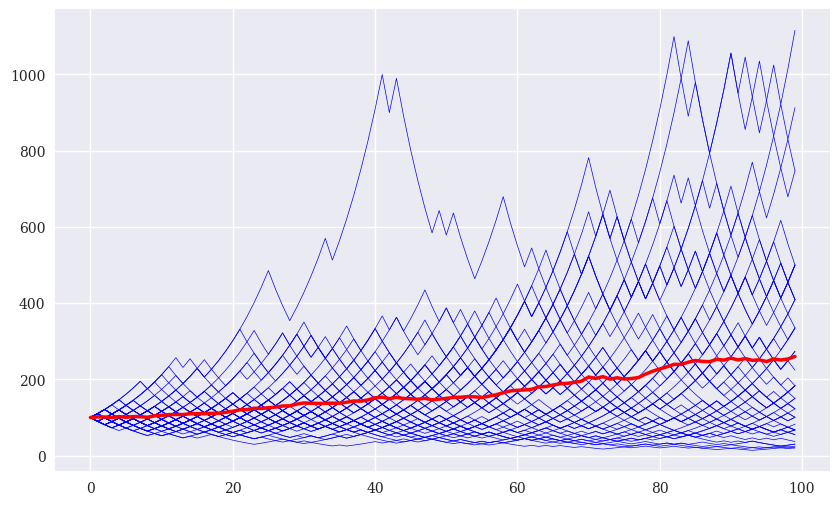

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(c_1, 'b', lw=0.5)
plt.plot(c_1.mean(axis=1), 'r', lw=2.5);

In [55]:
c_2 = run_simulation(0.05)

In [56]:
c_3 = run_simulation(0.25)

In [57]:
c_4 = run_simulation(0.5)

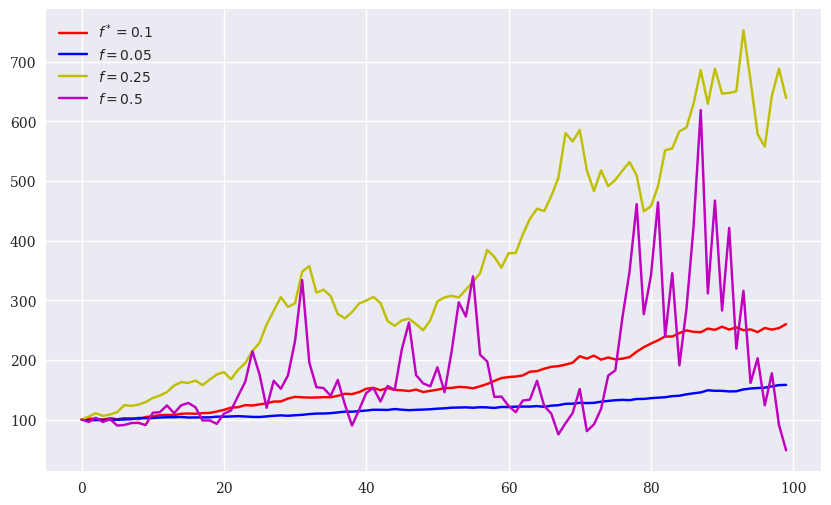

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(c_1.mean(axis=1), 'r', label='$f^*=0.1$')
plt.plot(c_2.mean(axis=1), 'b', label='$f=0.05$')
plt.plot(c_3.mean(axis=1), 'y', label='$f=0.25$')
plt.plot(c_4.mean(axis=1), 'm', label='$f=0.5$')
plt.legend(loc=0);

### Kelly Criterion for Stocks and Indices

In [59]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)

In [60]:
symbol = '.SPX'

In [61]:
data = pd.DataFrame(raw[symbol])

In [62]:
data['return'] = np.log(data / data.shift(1))

In [63]:
data.dropna(inplace=True)

In [64]:
data.tail()

,.SPX,return
Date,,
2019-12-23,3224.01,0.000866
2019-12-24,3223.38,-0.000195
2019-12-27,3240.02,0.000034
2019-12-30,3221.29,-0.005798
2019-12-31,3230.78,0.002942


In [65]:
mu = data['return'].mean() * 252

In [66]:
mu

np.float64(0.09992181916534204)

In [67]:
sigma = data['return'].std() * 252 ** 0.5

In [68]:
sigma

0.14761569775486583

In [69]:
r = 0.0

In [70]:
f = (mu - r) / sigma ** 2 # <5>

In [71]:
f

np.float64(4.585590244019806)

In [72]:
equs = []

In [73]:
def kelly_strategy(f):
    global equs
    equ = 'equity_{:.2f}'.format(f)
    equs.append(equ)
    cap = 'capital_{:.2f}'.format(f)
    data[equ] = 1
    data[cap] = data[equ] * f
    for i, t in enumerate(data.index[1:]):
        t_1 = data.index[i]
        data.loc[t, cap] = data[cap].loc[t_1] * \
                            math.exp(data['return'].loc[t])
        data.loc[t, equ] = data[cap].loc[t] - \
                            data[cap].loc[t_1] + \
                            data[equ].loc[t_1]
        data.loc[t, cap] = data[equ].loc[t] * f

In [74]:
kelly_strategy(f * 0.5)

In [75]:
kelly_strategy(f * 0.66)

In [76]:
kelly_strategy(f)

In [77]:
print(data[equs].tail())

            equity_2.29  equity_3.03  equity_4.59
Date                                             
2019-12-23     6.628865     9.585294    14.205748
2019-12-24     6.625895     9.579626    14.193019
2019-12-27     6.626410     9.580610    14.195229
2019-12-30     6.538582     9.412991    13.818934
2019-12-31     6.582748     9.496919    14.005618


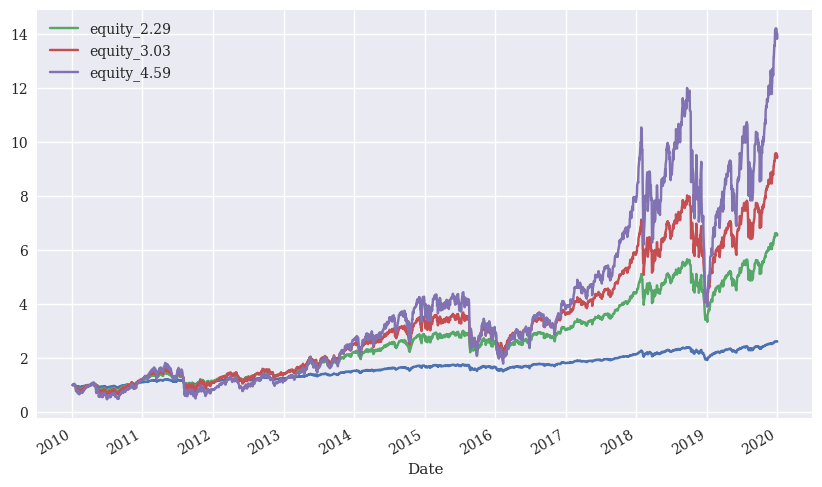

In [78]:
ax = data['return'].cumsum().apply(np.exp).plot(figsize=(10, 6))
data[equs].plot(ax=ax, legend=True);

## ML-Based Trading Strategy

### Vectorized Backtesting

In [79]:
import tpqoa

In [80]:
%time api = tpqoa.tpqoa('../pyalgo.cfg')

CPU times: user 920 μs, sys: 40 μs, total: 960 μs
Wall time: 876 μs


In [81]:
instrument = 'EUR_USD'


In [86]:
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import pandas as pd
from datetime import datetime

# Configuration de l'API
api_key = "101-305-3091856-001"
instrument = "EUR_USD"  # ou votre instrument

# Créer une instance de l'API
api = oandapyV20.API(access_token=api_key)

# Paramètres pour la requête d'historique
params = {
    "from": "2020-06-08T00:00:00Z",
    "to": "2020-06-13T00:00:00Z",
    "granularity": "M10",
    "price": "M"
}

# Créer une requête pour obtenir les données historiques de l'instrument
request = instruments.InstrumentsCandles(instrument=instrument, params=params)

# Exécuter la requête
api.request(request)

# Obtenir les données de la réponse
response = request.response
candles = response.get('candles', [])

# Convertir les données en DataFrame pour faciliter l'analyse
raw = []
for candle in candles:
    time = candle.get('time')
    mid = candle.get('mid', {})

    raw.append({
        'time': time,
        'open': float(mid.get('o')),
        'high': float(mid.get('h')),
        'low': float(mid.get('l')),
        'close': float(mid.get('c')),
        'volume': candle.get('volume')
    })

df = pd.DataFrame(raw)



V20Error: {"errorMessage":"Insufficient authorization to perform request."}

In [ ]:
raw = api.get_history(instrument,
                       start='2020-06-08',
                       end='2020-06-13',
                       granularity='M10',
                       price='M')

In [ ]:
raw.tail()

In [ ]:
raw.info()

In [ ]:
spread = 0.00012

In [ ]:
mean = raw['c'].mean()

In [ ]:
ptc = spread / mean
ptc

In [ ]:
raw['c'].plot(figsize=(10, 6), legend=True);

In [ ]:
data = pd.DataFrame(raw['c'])

In [ ]:
data.columns = [instrument,]

In [ ]:
window = 20
data['return'] = np.log(data / data.shift(1))
data['vol'] = data['return'].rolling(window).std()
data['mom'] = np.sign(data['return'].rolling(window).mean())
data['sma'] = data[instrument].rolling(window).mean()
data['min'] = data[instrument].rolling(window).min()
data['max'] = data[instrument].rolling(window).max()

In [ ]:
data.dropna(inplace=True)

In [ ]:
lags = 6

In [ ]:
features = ['return', 'vol', 'mom', 'sma', 'min', 'max']

In [ ]:
cols = []
for f in features:
    for lag in range(1, lags + 1):
        col = f'{f}_lag_{lag}'
        data[col] = data[f].shift(lag)
        cols.append(col)

In [ ]:
data.dropna(inplace=True)

In [ ]:
data['direction'] = np.where(data['return'] > 0, 1, -1)

In [ ]:
data[cols].iloc[:lags, :lags]

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
n_estimators=15
random_state=100
max_depth=2
min_samples_leaf=15
subsample=0.33

In [ ]:
dtc = DecisionTreeClassifier(random_state=random_state,
                             max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf)

In [ ]:
model = AdaBoostClassifier(base_estimator=dtc,
                          n_estimators=n_estimators,
                          random_state=random_state)

In [ ]:
split = int(len(data) * 0.7)

In [ ]:
train = data.iloc[:split].copy()

In [ ]:
mu, std = train.mean(), train.std()

In [ ]:
train_ = (train - mu) / std

In [ ]:
model.fit(train_[cols], train['direction'])

In [ ]:
accuracy_score(train['direction'], model.predict(train_[cols]))

In [ ]:
test = data.iloc[split:].copy()

In [ ]:
test_ = (test - mu) / std

In [ ]:
test['position'] = model.predict(test_[cols])

In [ ]:
accuracy_score(test['direction'], test['position'])

In [ ]:
test['strategy'] = test['position'] * test['return']

In [ ]:
sum(test['position'].diff() != 0)

In [ ]:
test['strategy_tc'] = np.where(test['position'].diff() != 0,
                               test['strategy'] - ptc,
                               test['strategy'])

In [ ]:
test[['return', 'strategy', 'strategy_tc']].sum(
        ).apply(np.exp)

In [ ]:
test[['return', 'strategy', 'strategy_tc']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));

In [ ]:
mean = test[['return', 'strategy_tc']].mean() * len(data) * 52
mean

In [ ]:
var = test[['return', 'strategy_tc']].var() * len(data) * 52
var

In [ ]:
vol = var ** 0.5
vol

In [ ]:
mean / var

In [ ]:
mean / var * 0.5

In [ ]:
to_plot = ['return', 'strategy_tc']  

In [ ]:
for lev in [10, 20, 30, 40, 50]:  
    label = 'lstrategy_tc_%d' % lev  
    test[label] = test['strategy_tc'] * lev
    to_plot.append(label)  

In [ ]:
test[to_plot].cumsum().apply(np.exp).plot(figsize=(10, 6));

### Risk Analysis

In [ ]:
equity = 3333

In [ ]:
risk = pd.DataFrame(test['lstrategy_tc_30'])

In [ ]:
risk['equity'] = risk['lstrategy_tc_30'].cumsum(
                          ).apply(np.exp) * equity

In [ ]:
risk['cummax'] = risk['equity'].cummax()

In [ ]:
risk['drawdown'] = risk['cummax'] - risk['equity']

In [ ]:
risk['drawdown'].max()

In [ ]:
t_max = risk['drawdown'].idxmax()
t_max

In [ ]:
temp = risk['drawdown'][risk['drawdown'] == 0]

In [ ]:
periods = (temp.index[1:].to_pydatetime() -
           temp.index[:-1].to_pydatetime())

In [ ]:
periods[20:30]

In [ ]:
t_per = periods.max()

In [ ]:
t_per

In [ ]:
t_per.seconds / 60 / 60

In [ ]:
risk[['equity', 'cummax']].plot(figsize=(10, 6))
plt.axvline(t_max, c='r', alpha=0.5);

In [ ]:
import scipy.stats as scs

In [ ]:
percs = [0.01, 0.1, 1., 2.5, 5.0, 10.0]

In [ ]:
risk['return'] = np.log(risk['equity'] /
                         risk['equity'].shift(1))

In [ ]:
VaR = scs.scoreatpercentile(equity * risk['return'], percs)

In [ ]:
def print_var():
    print('{}    {}'.format('Confidence Level', 'Value-at-Risk'))
    print(33 * '-')
    for pair in zip(percs, VaR):
        print('{:16.2f} {:16.3f}'.format(100 - pair[0], -pair[1])) 

In [ ]:
print_var()

In [ ]:
hourly = risk.resample('1H', label='right').last()

In [ ]:
hourly['return'] = np.log(hourly['equity'] /
                         hourly['equity'].shift(1))

In [ ]:
VaR = scs.scoreatpercentile(equity * hourly['return'], percs)

In [ ]:
print_var()

### Persisting the Model Object

In [ ]:
import pickle

In [ ]:
algorithm = {'model': model, 'mu': mu, 'std': std}

In [ ]:
pickle.dump(algorithm, open('algorithm.pkl', 'wb'))

## Online Algorithm

In [ ]:
algorithm = pickle.load(open('algorithm.pkl', 'rb'))

In [ ]:
algorithm['model']

In [ ]:
class MLTrader(tpqoa.tpqoa):
    def __init__(self, config_file, algorithm):
        super(MLTrader, self).__init__(config_file)
        self.model = algorithm['model']
        self.mu = algorithm['mu']
        self.std = algorithm['std']
        self.units = 100000
        self.position = 0
        self.bar = '5s'
        self.window = 2
        self.lags = 6
        self.min_length = self.lags + self.window + 1
        self.features = ['return', 'vol', 'mom', 'sma', 'min', 'max']
        self.raw_data = pd.DataFrame()
    def prepare_features(self):
        self.data['return'] = np.log(self.data['mid'] /
                                     self.data['mid'].shift(1))
        self.data['vol'] = self.data['return'].rolling(
            self.window).std()
        self.data['mom'] = np.sign(
            self.data['return'].rolling(self.window).mean())
        self.data['sma'] = self.data['mid'].rolling(self.window).mean()
        self.data['min'] = self.data['mid'].rolling(self.window).min()
        self.data['max'] = self.data['mid'].rolling(self.window).max()
        self.data.dropna(inplace=True)
        self.data[self.features] -= self.mu
        self.data[self.features] /= self.std
        self.cols = []
        for f in self.features:
            for lag in range(1, self.lags + 1):
                col = f'{f}_lag_{lag}'
                self.data[col] = self.data[f].shift(lag)
                self.cols.append(col)
    def on_success(self, time, bid, ask):
        # print(self.ticks, 20 * ' ', end='\r')
        df = pd.DataFrame({'bid': float(bid), 'ask': float(ask)},
                         index=[pd.Timestamp(time).tz_localize(None)])
        self.raw_data = pd.concat((self.raw_data, df))
        self.data = self.raw_data.resample(self.bar,
                                label='right').last().ffill()
        self.data = self.data.iloc[:-1]
        if len(self.data) > self.min_length:
            self.min_length +=1
            self.data['mid'] = (self.data['bid'] +
                                self.data['ask']) / 2
            self.prepare_features()
            features = self.data[
                self.cols].iloc[-1].values.reshape(1, -1)
            signal = self.model.predict(features)[0]
            print(f'NEW SIGNAL: {signal}', end='\r')
            if self.position in [0, -1] and signal == 1:
                print('*** GOING LONG ***')
                self.create_order(self.stream_instrument,
                            units=(1 - self.position) * self.units)
                self.position = 1
            elif self.position in [0, 1] and signal == -1:
                print('*** GOING SHORT ***')
                self.create_order(self.stream_instrument,
                            units=-(1 + self.position) * self.units)
                self.position = -1

In [ ]:
mlt = MLTrader('../../pyalgo.cfg', algorithm)

In [ ]:
mlt.stream_data(instrument, stop=250)
print('*** CLOSING OUT ***')
mlt.create_order(mlt.stream_instrument,
                  units=-mlt.position * mlt.units)

## Logging and Monitoring

In [ ]:
!cat automated_strategy.py

In [ ]:
!cat strategy_monitoring.py

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:training@tpq.io">training@tpq.io</a>